In [2]:
import pandas as pd
import numpy as np


from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

### Abrindo o arquivo

In [3]:
#criando dataframes
esc_rmsp = pd.read_csv('ESC2013_RMSP_CEM.csv', encoding = 'latin1')
nota = pd.read_csv('ENEM2015.csv')

#agrupamento por escolas
esc_rmsp = esc_rmsp.groupby('CODESC').mean()
esc_rmsp = esc_rmsp.reset_index()

#apagando a classe desbalanceada
nota = nota[nota.Classificacao != 0]

#Alterando o nome da coluna de acordo com os outros dataframes
nota.rename(columns = {'CODIGO DA ENTIDADE':'CODMEC'}, inplace = True)
esc_rmsp.rename(columns = {'CODESC':'CODMEC'}, inplace = True)

#apgando as escolas que não estão no target
esc_rmsp = esc_rmsp[esc_rmsp.CODMEC.isin(nota['CODMEC'])]

print("\tshapes com NaN's:")
print('esc_rmsp: ', esc_rmsp.shape)

#colunas que apresentam dados anuais
cols = ['ID', 'LONGITUDE', 'LATITUDE', 'CODESCTX', 'CODMUN', 'CODDIST', 'COD_SC','CEP', 'LOCALIZA', 'QD_ESP_C', 'QD_ESP_D']
cols_reg = ['ENS_REG', 'REG_IN_CR', 'REG_IN_PE', 'REG_FU_8A', 'REG_FU_9A',
            'REG_MED', 'REG_MED_I', 'REG_MED_N', 'REG_MED_P']
cols_esp = ['ENS_ESP', 'ESP_IN_CR', 'ESP_IN_PE', 'ESP_FU_8A', 'ESP_FU_9A',
            'ESP_MED', 'ESP_MED_I', 'ESP_MED_N', 'ESP_MED_P']
cols_eja = ['ESP_EJA_F', 'ESP_EJA_M', 'EJA', 'EJA_FUND', 'EJA_MED', 'EJA_PROJ']
cols_aprov = ['AP5EF_07', 'AP9EF_07', 'AP3EM_07', 'AP5EF_08' , 'AP9EF_08', 'AP3EM_08',
             'AP5EF_09', 'AP9EF_09', 'AP3EM_09', 'AP5EF_10', 'AP9EF_10', 'AP3EM_10',
             'AP5EF_11', 'AP9EF_11', 'APR3EM_11', 'AP5EF_12', 'AP9EF_12', 'AP3EM_12',
             'AP5EF_13', 'AP9EF_13', 'AP3EM_13', 'AP5EF_14', 'AP9EF_14', 'AP3EM_14']
cols_aban = ['AB1EM_07', 'AB1EM_08', 'AB1EM_09', 'AB1EM_10', 'AB1EM_11', 'AB1EM_12', 'AB1EM_13', 'AB1EM_14']
cols_dist = ['DI3EM_07', 'DI3EM_08', 'DI3EM_09', 'DI3EM_10','DI3EM_11', 'DI3EM_12', 'DI3EM_13', 'DI3EM_14']
cols_pbras_inic = ['MAT05_AI', 'LP05_AI', 'NP05_AI', 'MAT07_AI', 'LP07_AI', 
            'NP07_AI','MAT09_AI', 'LP09_AI', 'NP09_AI', 'MAT11_AI', 'LP11_AI',
            'NP11_AI', 'MAT13_AI', 'LP13_AI', 'NP13_AI']
cols_ideb_inic = ['IDEB05AI', 'IDEB07AI', 'IDEB09AI', 'IDEB11AI', 'IDEB13AI']
cols_pbras_fin = ['MAT05_AF', 'LP05_AF', 'NP05_AF', 'MAT07_AF', 'LP07_AF', 
                   'NP07_AF', 'MAT09_AF', 'LP09_AF', 'NP09_AF', 'MAT11_AF', 
                   'LP11_AF', 'NP11_AF', 'MAT13_AF', 'LP13_AF', 'NP13_AF']
cols_ideb_fin = ['IDEB05AF', 'IDEB07AF', 'IDEB09AF', 'IDEB11AF', 'IDEB13AF']
cols_enem = ['RED_EN13', 'LC_EN13', 'MAT_EN13', 'CH_EN13', 'CN_EN13', 'ENEM2013']
cols_inse = ['INSE_AB']
esc_rmsp.drop(cols, axis = 1, inplace = True)

	shapes com NaN's:
esc_rmsp:  (1241, 126)


	shapes sem NaN's:
esc_rmsp:  (1241, 14)


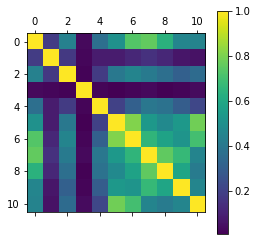

In [4]:
#mantendo colunas principais e apagando secundarias
cols_reg.remove('ENS_REG')
cols_esp.remove('ENS_ESP')
cols_eja.remove('EJA')
cols_enem.remove('ENEM2013')
media_esc_rmsp = esc_rmsp.drop(cols_reg + cols_esp + cols_eja + cols_enem, axis =1)

#realizando a média de colunas anuais
cols_pbras = ['NP05_AI', 'NP07_AI', 'NP09_AI', 'NP11_AI', 'NP13_AI', 
              'NP05_AF', 'NP07_AF', 'NP09_AF', 'NP11_AF', 'NP13_AF']
media_esc_rmsp['MEDIA_APROV'] = media_esc_rmsp[cols_aprov].mean(axis = 1)
media_esc_rmsp['MEDIA_ABAN'] = media_esc_rmsp[cols_aban].mean(axis = 1)
media_esc_rmsp['MEDIA_DIST'] = media_esc_rmsp[cols_dist].mean(axis = 1)
media_esc_rmsp['MEDIA_IDEB'] = media_esc_rmsp[cols_ideb_fin + cols_ideb_inic].mean(axis = 1)
media_esc_rmsp['MEDIA_PBRAS'] = media_esc_rmsp[cols_pbras].mean(axis = 1)
media_esc_rmsp.drop(cols_aprov + cols_aban + cols_dist + cols_ideb_fin + cols_ideb_inic + cols_pbras_inic + cols_pbras_fin , axis = 1, inplace = True)
print("\tshapes sem NaN's:")
print('esc_rmsp: ', media_esc_rmsp.shape)
media_esc_rmsp.drop(['MEDIA_IDEB', 'MEDIA_PBRAS'], axis = 1, inplace = True)
plt.matshow(pd.merge(media_esc_rmsp, nota, on = 'CODMEC').drop(['NUMERO DE PARTICIPANTES', 'ENS_REG', 'CODMEC'], axis = 1).corr().abs())
plt.colorbar()
plt.show()

### Classificador random forest

In [5]:
data = pd.merge(media_esc_rmsp, nota, on = 'CODMEC').drop(['CODMEC', 'NUMERO DE PARTICIPANTES'], axis = 1)
for col in data.columns[data.dtypes == 'int64']:
    data[col] = data[col].astype('float64')
data.dropna(how = 'any', inplace = True)
target = data.Classificacao
data.drop(['Classificacao'], axis = 1, inplace = True)

In [6]:
scaler = StandardScaler()
colunas = data.columns
data = pd.DataFrame(scaler.fit_transform(data), columns = colunas)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 41)
clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
clf.fit(x_train, y_train)
print('Score nos dados de treino: ', clf.score(x_train,y_train))
print('Score nos dados de teste: ', clf.score(x_test,y_test))
features_imp = list(zip(clf.feature_importances_, colunas))
features_imp.sort(reverse = True)
features_imp = [(b,a) for (a,b) in features_imp]
print('\n----------------------')
print('Coluna \t\t valor da coluna')
for (a,b) in features_imp:
    if len(a) > 7:
        print(str(a) + '\t' + str(b))
    else:
        print(str(a) + '\t\t' + str(b))

Score nos dados de treino:  0.8051075268817204
Score nos dados de teste:  0.8449197860962567

----------------------
Coluna 		 valor da coluna
ENEM2013	0.377274455779301
INSE_AB		0.3477047101607952
MEDIA_DIST	0.09816957910631355
MEDIA_APROV	0.07972107157378312
COD_DEP		0.06072726692151157
MEDIA_ABAN	0.027050241374967986
BIBLIO		0.006687812103520594
LAB_INF		0.0026648629798069314
ENS_REG		0.0
ENS_ESP		0.0
EJA		0.0


### Visualização comparando as classes reais e a previsão da RandomForest nos dados de teste

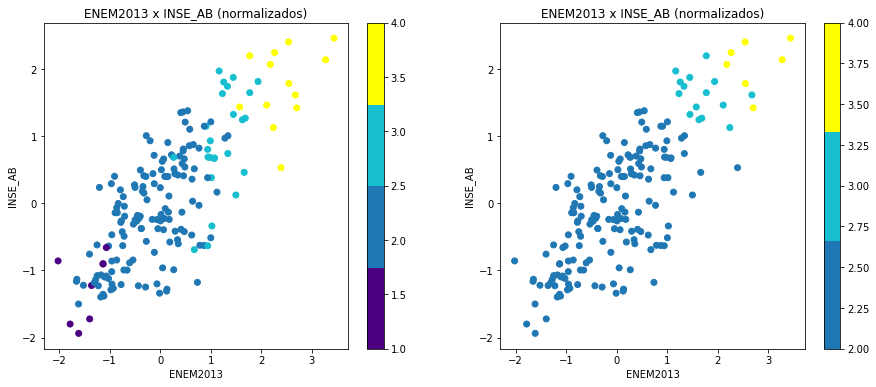

In [7]:
plt.figure(figsize = (15,6))
colormap = ['indigo', 'tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,1)
plt.scatter(x_test.ENEM2013, x_test.INSE_AB, c = y_test, cmap=mpl.colors.ListedColormap(colormap))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
colormap2 = ['tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,2)
plt.scatter(x_test.ENEM2013, x_test.INSE_AB, c = clf.predict(x_test), cmap=mpl.colors.ListedColormap(colormap2))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.show()

### Visualização comparando as classes reais e a previsão da RandomForest nos dados gerais

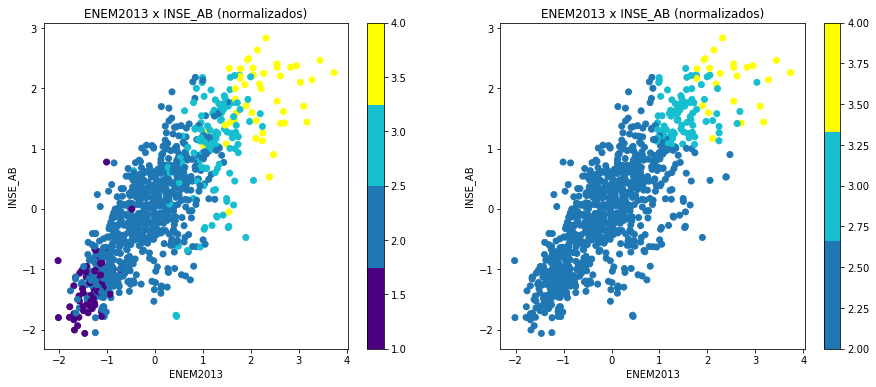

In [8]:
plt.figure(figsize = (15,6))
colormap = ['indigo', 'tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,1)
plt.scatter(data.ENEM2013, data.INSE_AB, c = target, cmap=mpl.colors.ListedColormap(colormap))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.subplot(1,2,2)
colormap2 = ['tab:blue', 'tab:cyan', 'yellow']
plt.scatter(data.ENEM2013, data.INSE_AB, c = clf.predict(data), cmap=mpl.colors.ListedColormap(colormap2))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.show()

Novamente obtivemos que algumas colunas não são relevantes para o fit do modelo.

In [9]:
x_axis = list(range(10,140))
y_axis1 = []
y_axis2 = []
for n_est in range(10, 140):
    clf = RandomForestClassifier(n_estimators=n_est, max_depth = 2, random_state=15)
    clf.fit(x_train, y_train)
    y_axis1.append(clf.score(x_test, y_test))
    y_axis2.append(clf.score(x_train, y_train))

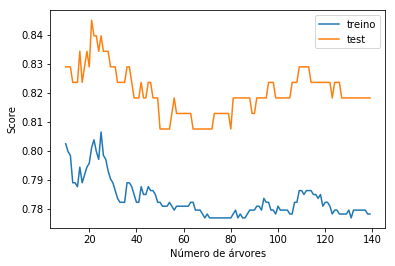

In [10]:
plt.plot(x_axis, y_axis2, label = 'treino')
plt.plot(x_axis, y_axis1, label = 'test')
plt.xlabel('Número de árvores')
plt.ylabel('Score')
plt.legend()
plt.show()

### Tentando lidar com a previsão da classe desbalanceada

In [11]:
scaler = StandardScaler()
colunas = data.columns
data = pd.DataFrame(scaler.fit_transform(data), columns = colunas)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 41)
clf = RandomForestClassifier(n_estimators=10, max_depth=2, class_weight= 'balanced_subsample', random_state=0)
clf.fit(x_train, y_train)
print('Score nos dados de treino: ', clf.score(x_train,y_train))
print('Score nos dados de teste: ', clf.score(x_test,y_test))
features_imp = list(zip(clf.feature_importances_, colunas))
features_imp.sort(reverse = True)
features_imp = [(b,a) for (a,b) in features_imp]
print('\n----------------------')
print('Coluna \t\t valor da coluna')
for (a,b) in features_imp:
    if len(a) > 7:
        print(str(a) + '\t' + str(b))
    else:
        print(str(a) + '\t\t' + str(b))

Score nos dados de treino:  0.7096774193548387
Score nos dados de teste:  0.732620320855615

----------------------
Coluna 		 valor da coluna
INSE_AB		0.3501976984272073
ENEM2013	0.3016688407843105
COD_DEP		0.11736822537208746
MEDIA_APROV	0.09388620449580345
MEDIA_DIST	0.08283455955207744
MEDIA_ABAN	0.04784637493250883
BIBLIO		0.00619809643600501
LAB_INF		0.0
ENS_REG		0.0
ENS_ESP		0.0
EJA		0.0


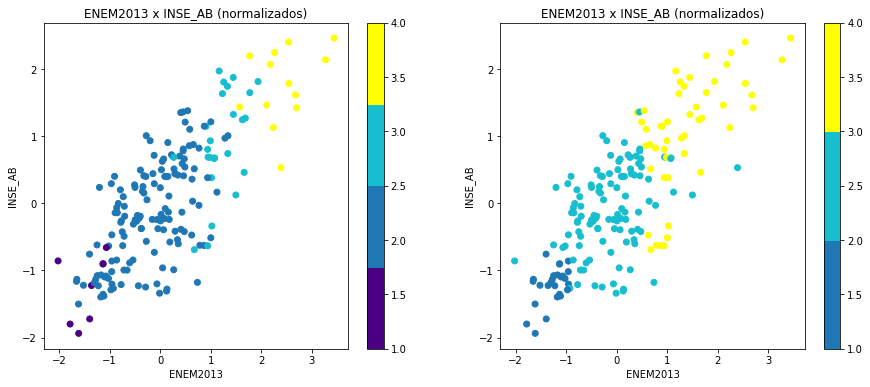

In [12]:
plt.figure(figsize = (15,6))
colormap = ['indigo', 'tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,1)
plt.scatter(x_test.ENEM2013, x_test.INSE_AB, c = y_test, cmap=mpl.colors.ListedColormap(colormap))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
colormap2 = ['tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,2)
plt.scatter(x_test.ENEM2013, x_test.INSE_AB, c = clf.predict(x_test), cmap=mpl.colors.ListedColormap(colormap2))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.show()

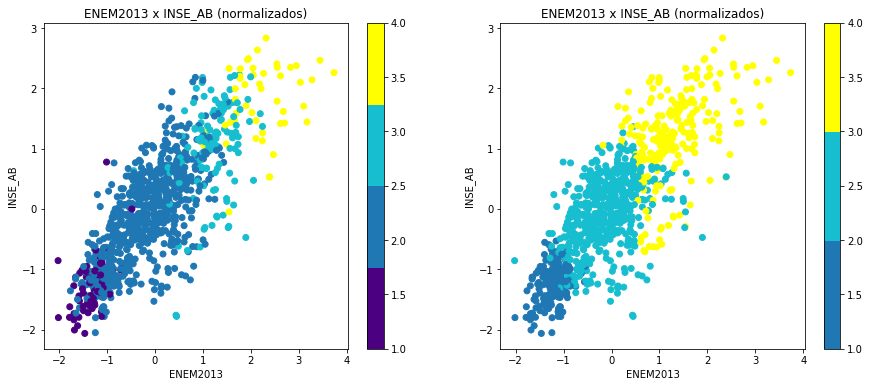

In [13]:
plt.figure(figsize = (15,6))
colormap = ['indigo', 'tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,1)
plt.scatter(data.ENEM2013, data.INSE_AB, c = target, cmap=mpl.colors.ListedColormap(colormap))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.subplot(1,2,2)
colormap2 = ['tab:blue', 'tab:cyan', 'yellow']
plt.scatter(data.ENEM2013, data.INSE_AB, c = clf.predict(data), cmap=mpl.colors.ListedColormap(colormap2))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.show()

In [14]:
 from imblearn.ensemble import BalancedRandomForestClassifier

In [15]:
scaler = StandardScaler()
colunas = data.columns
data = pd.DataFrame(scaler.fit_transform(data), columns = colunas)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 41)
clf = BalancedRandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
clf.fit(x_train, y_train)
print('Score nos dados de treino: ', clf.score(x_train,y_train))
print('Score nos dados de teste: ', clf.score(x_test,y_test))
features_imp = list(zip(clf.feature_importances_, colunas))
features_imp.sort(reverse = True)
features_imp = [(b,a) for (a,b) in features_imp]
print('\n----------------------')
print('Coluna \t\t valor da coluna')
for (a,b) in features_imp:
    if len(a) > 7:
        print(str(a) + '\t' + str(b))
    else:
        print(str(a) + '\t\t' + str(b))

Score nos dados de treino:  0.6626344086021505
Score nos dados de teste:  0.6684491978609626

----------------------
Coluna 		 valor da coluna
MEDIA_ABAN	0.2539776349245563
ENEM2013	0.20638396812557694
INSE_AB		0.20471266621363599
MEDIA_DIST	0.18426404035678992
COD_DEP		0.10608529177168032
MEDIA_APROV	0.025549062319058367
BIBLIO		0.01902733628870219
LAB_INF		0.0
ENS_REG		0.0
ENS_ESP		0.0
EJA		0.0


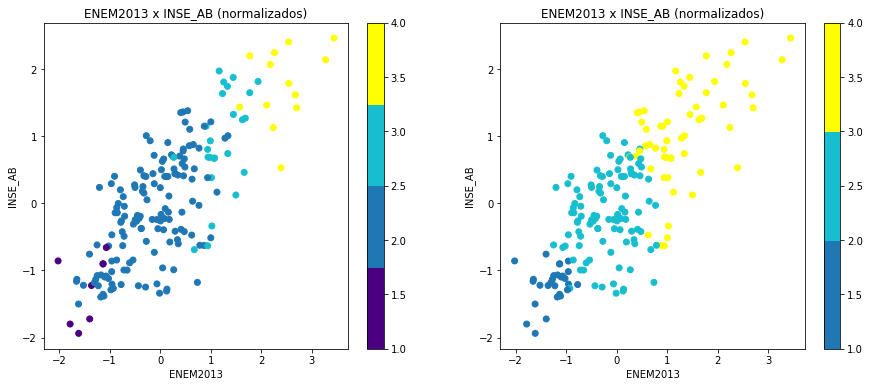

In [16]:
plt.figure(figsize = (15,6))
colormap = ['indigo', 'tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,1)
plt.scatter(x_test.ENEM2013, x_test.INSE_AB, c = y_test, cmap=mpl.colors.ListedColormap(colormap))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
colormap2 = ['tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,2)
plt.scatter(x_test.ENEM2013, x_test.INSE_AB, c = clf.predict(x_test), cmap=mpl.colors.ListedColormap(colormap2))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.show()

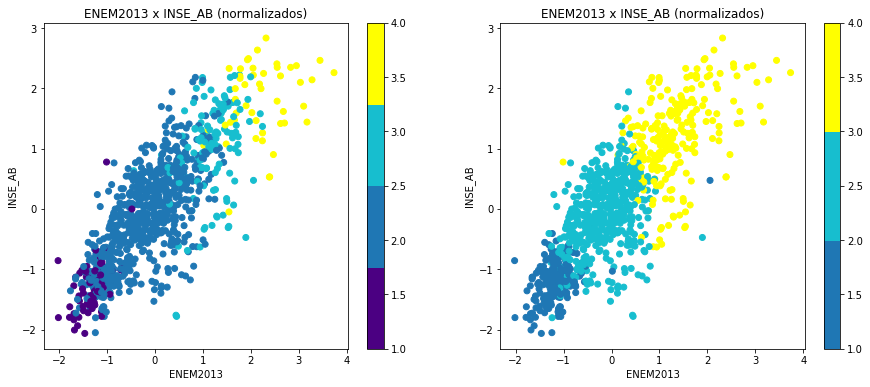

In [17]:
plt.figure(figsize = (15,6))
colormap = ['indigo', 'tab:blue', 'tab:cyan', 'yellow']
plt.subplot(1,2,1)
plt.scatter(data.ENEM2013, data.INSE_AB, c = target, cmap=mpl.colors.ListedColormap(colormap))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.subplot(1,2,2)
colormap2 = ['tab:blue', 'tab:cyan', 'yellow']
plt.scatter(data.ENEM2013, data.INSE_AB, c = clf.predict(data), cmap=mpl.colors.ListedColormap(colormap2))
plt.xlabel('ENEM2013')
plt.ylabel('INSE_AB')
plt.title('ENEM2013 x INSE_AB (normalizados)')
plt.colorbar()
plt.show()